In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u 
from astropy.constants import G, M_jup, R_jup, sigma_sb, R_earth, R_sun
from popsims import sample_from_powerlaw #popsims is pip installable
from popsims import EvolutionaryModel, EVOL_MODELS
#some built im evolutionary model
plt.style.use('/users/caganze/style.mpl')

In [2]:
#functions
def dm_power(rho_DM, m, r):
    #compute the total lumonsity from dark matter
    #given a mass and a radius of an object
    f= 1
    sigma_DM= 184*u.km/u.s
    v_DM=200*u.km/u.s
    vesc= np.sqrt(2*G*m/r) #escape velocity
    #return the power in solar luminosity
    return (f*np.pi*r**2*rho_DM*v_DM*(1+1.5*vesc**2/sigma_DM**2)).to(u.Lsun)

def add_dm_heat(data, dm_flux):
    #add dark matter flux to an evolutionary model grid
    #read an evolutionary model
    lum= (10**data['luminosity'].values)*u.Lsun
    radius= data['radius'].values*u.Rsun
    mass= data['mass'].values*u.Msun
    dm_lum= dm_power(dm_flux,mass, radius)
    #compute new temperature
    tot_lum= (lum+dm_lum).to(u.Watt)
    dm_teff= (tot_lum/(4*np.pi*radius**2*sigma_sb))**(1/4)
    teff_black= (lum.to(u.Watt)/(4*np.pi*radius**2*sigma_sb))**(1/4)
    #teff from black body (this not the same teff reported here)
    data['dm_luminosity']= dm_lum.to(u.Lsun).value
    data['tot_luminosity']= tot_lum.to(u.Lsun).value
    data['dm_teff']= dm_teff.to(u.Kelvin).value
    data['b_teff']= teff_black.to(u.Kelvin).value

    return data

def get_luminosity_function(data, interp_col='dm_teff',nsample=1e6, min_mass=0.001, max_mass=0.1):

    mass=sample_from_powerlaw(-0.6,xmin=min_mass, xmax=max_mass, nsample=int(nsample))
    #uniform age from 0 to 13.5Gyr
    age=np.random.uniform(1e-3, 14, len(mass))
    lmass=np.log10(mass)
    lage= np.log10(age)
    #generate an evol model object
    evol_model=EvolutionaryModel(data)
    #interpolate
    res=evol_model.interpolate('mass','age', lmass, lage, \
                                        logscale=['mass', 'age',interp_col], \
                                            interp_columns=[interp_col])
    #return evolutionary_model_interpolator(mass, age, self.evolmodel)
    res['mass']=mass
    res['age']=age
    res[interp_col]=10**res[interp_col].values

    return res

def normalized_lf(temperatures):
    #normalize at 1500 K bin based on the local luminosity function
    #go from histogram of teffs to a number like /150 K bin/ pc^-3
    bin_edges = np.arange(100, 3000, 150)
    # Compute histogram
    counts, edges = np.histogram(temperatures, bins=bin_edges, density=False)
    
    # Normalize by area (height * bin width = area = 1)
    bin_widths = np.diff(edges)
    area = np.sum(counts * bin_widths)
    hist = counts / area  # area-normalized
    
    # Find the index of the bin that includes [1050, 1200] Kelvin
    target_index = np.where((edges[:-1] <= 1650) & (edges[1:] > 1500))[0]
    if len(target_index) == 0:
        raise ValueError("No bin found that covers 1050–1200 range.")
    
    idx = target_index[0]

    # Scale entire histogram so that this bin becomes 1.11

    scale_factor =0.81e-3 / hist[idx] 
    hist_scaled = hist * scale_factor

    return hist_scaled, edges

    


In [3]:
EVOL_MODELS.keys()

dict_keys(['saumon2008', 'baraffe1997_metalpoor', 'baraffe1998', 'burrows2001', 'phillips2020', 'baraffe2003', 'marley2019', 'baraffe2015', 'burrows1997', 'chabrier1997', 'baraffe1998_metalpoor', 'roman2020', 'baraffe1997'])

In [4]:
saumon=pd.DataFrame(EVOL_MODELS['saumon2008']) #they have clouds
atmo= pd.DataFrame(EVOL_MODELS['phillips2020']) 
marley= pd.DataFrame(EVOL_MODELS['marley2019']) #an old sonora grid
mpoor= pd.DataFrame(EVOL_MODELS['baraffe1997_metalpoor']) #an old grid that has a different chemistry


saumon

,age,mass,luminosity,temperature,gravity,radius,metallicity,cloud
0,0.003,0.002,-4.721,998,3.411,0.1458,-0.3,nc
1,0.003,0.002,-4.764,933,3.338,0.1586,0.0,f2
2,0.003,0.002,-4.640,1027,3.380,0.1512,0.0,hybrid
3,0.003,0.002,-4.698,998,3.389,0.1496,0.0,nc
4,0.003,0.002,-4.692,987,3.363,0.1540,0.3,nc
...,...,...,...,...,...,...,...,...
4536,15.000,0.074,-4.121,1810,5.414,0.0884,0.0,nc
4537,15.000,0.075,-4.006,1912,5.400,0.0905,0.0,nc
4538,15.000,0.077,-3.830,2074,5.376,0.0942,0.0,nc
4539,15.000,0.080,-3.645,2248,5.348,0.0992,0.0,nc


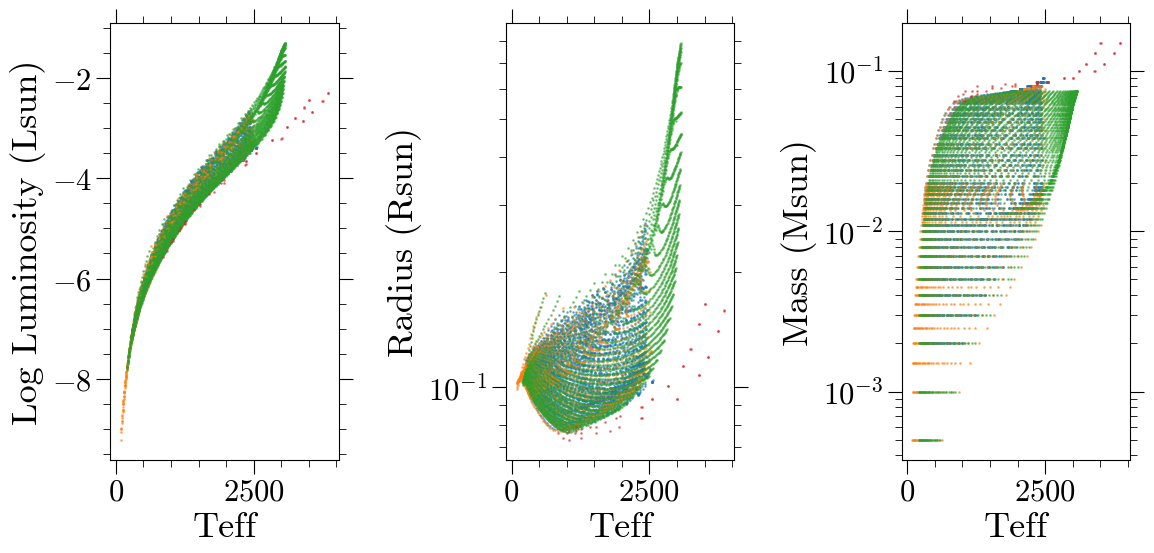

In [5]:
fig, axs=plt.subplots(ncols=3, figsize=(12, 6))
ax=axs[0]
ax.scatter(saumon['temperature'], saumon['luminosity'],s=1, alpha=0.5)
ax.scatter(marley['temperature'], marley['luminosity'], s=1, alpha=0.5)
ax.scatter(atmo['temperature'], atmo['luminosity'], s=1, alpha=0.5)
ax.scatter(mpoor['temperature'], mpoor['luminosity'], s=1, alpha=0.5)
ax.set( xlabel='Teff', ylabel='Log Luminosity (Lsun)')

ax=axs[1]
ax.scatter(saumon['temperature'], saumon['radius'],s=1, alpha=0.5)
ax.scatter(marley['temperature'], marley['radius'], s=1, alpha=0.5)
ax.scatter(atmo['temperature'], atmo['radius'], s=1, alpha=0.5)
ax.scatter(mpoor['temperature'], mpoor['radius'], s=1, alpha=0.5)
ax.set( xlabel='Teff', ylabel='Radius (Rsun)', yscale='log')
plt.tight_layout()

ax=axs[-1]
ax.scatter(saumon['temperature'], saumon['mass'], s=1, alpha=0.5)
ax.scatter(marley['temperature'], marley['mass'], s=1, alpha=0.5)
ax.scatter(atmo['temperature'], atmo['mass'], s=1, alpha=0.5)
ax.scatter(mpoor['temperature'], mpoor['mass'], s=1, alpha=0.5)
ax.set( xlabel='Teff', ylabel='Mass (Msun)', yscale='log')
plt.tight_layout()

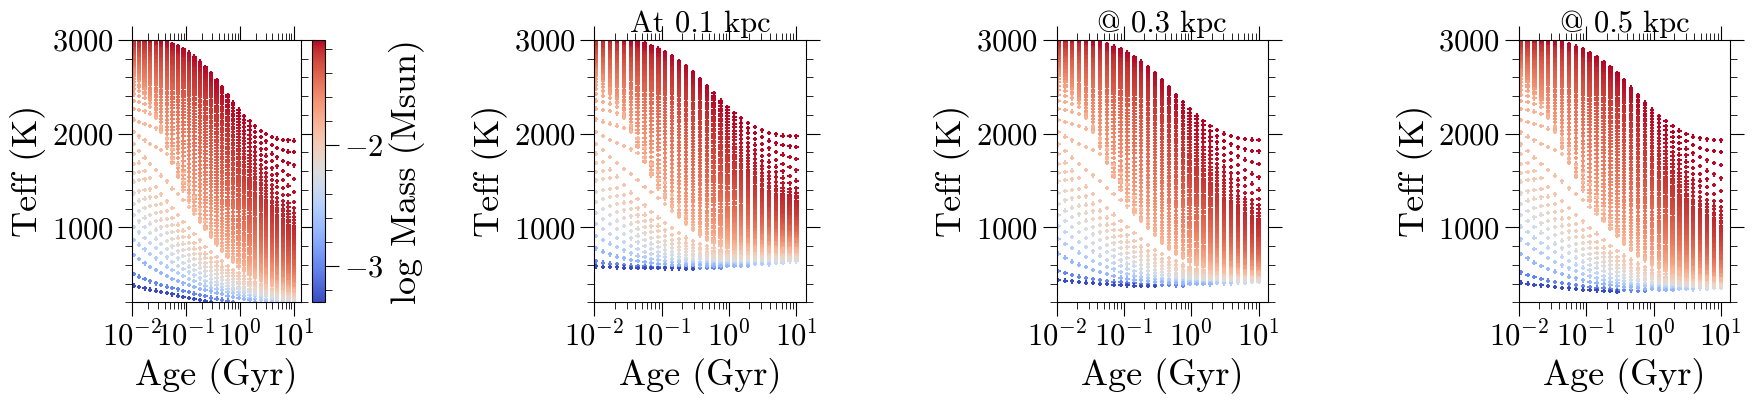

In [6]:
#add dark matter
cmap='coolwarm'
data=atmo
fig, axs=plt.subplots(ncols=4, figsize=(18, 4.5))
ax=axs[0]
c=ax.scatter(data['age'], data['temperature'], c=np.log10(data['mass']), marker='+', s=10, cmap=cmap)
plt.colorbar(c, label='log Mass (Msun)')

ax=axs[1]
#add heat at 
dm_data=add_dm_heat(data, 636e9*u.eV/u.cm**3)
ax.scatter(dm_data['age'], dm_data['dm_teff'], c=np.log10(dm_data['mass']), marker='+', s=10, cmap=cmap)
ax.set( title='At 0.1 kpc')

ax=axs[2]
#add heat at 
dm_data=add_dm_heat(data, 116e9*u.eV/u.cm**3)
ax.scatter(dm_data['age'], dm_data['dm_teff'], c=np.log10(dm_data['mass']), marker='+', s=10, cmap=cmap)
ax.set( title='@ 0.3 kpc')


ax=axs[3]
#add heat at 
dm_data=add_dm_heat(data, 54e9*u.eV/u.cm**3)
ax.scatter(dm_data['age'], dm_data['dm_teff'], c=np.log10(dm_data['mass']), marker='+', s=10, cmap=cmap)

ax.set( title='@ 0.5 kpc')

for a in axs:
    a.set(ylabel='Teff (K)', xlabel='Age (Gyr)', xlim=[1e-2, 13.7],  ylim=[200, 3000], xscale='log')
plt.tight_layout()


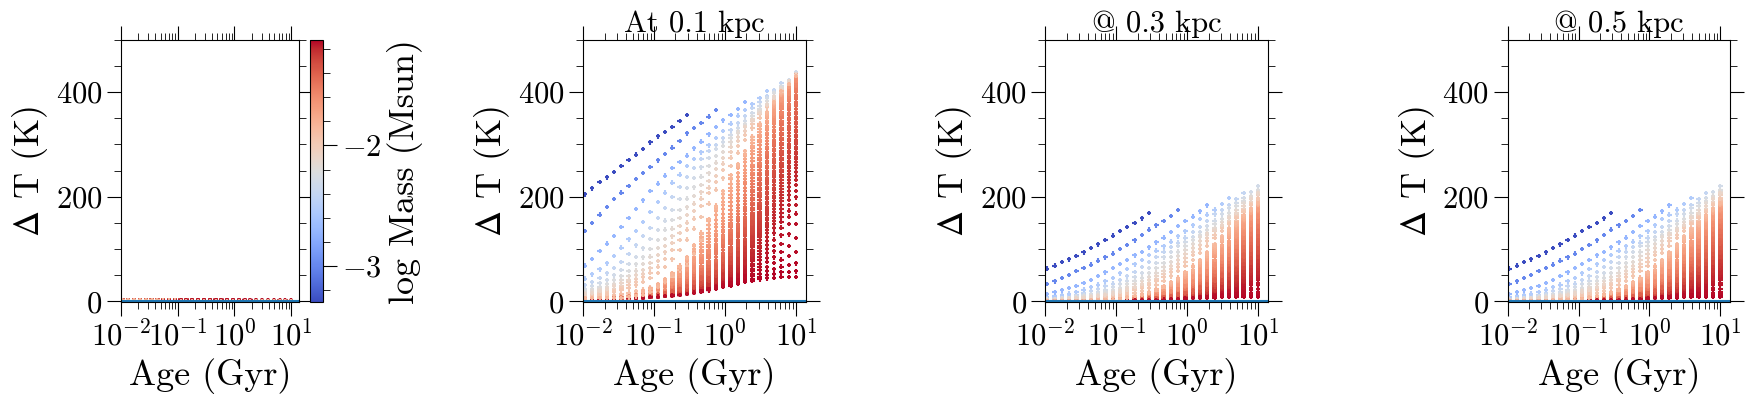

In [7]:
#add dark matter
cmap='coolwarm'
fig, axs=plt.subplots(ncols=4, figsize=(18, 4.5))
ax=axs[0]
c=ax.scatter(data['age'], data['temperature']-dm_data['b_teff'], c=np.log10(data['mass']), marker='+', s=10, cmap=cmap)
plt.colorbar(c, label='log Mass (Msun)')

ax=axs[1]
#add heat at 
dm_data=add_dm_heat(data, 636e9*u.eV/u.cm**3)
ax.scatter(dm_data['age'], dm_data['dm_teff']-dm_data['b_teff'], c=np.log10(dm_data['mass']), marker='+', s=10, cmap=cmap)
ax.set( title='At 0.1 kpc')

ax=axs[2]
#add heat at 
dm_data=add_dm_heat(data, 116e9*u.eV/u.cm**3)
ax.scatter(dm_data['age'], dm_data['dm_teff']-dm_data['b_teff'], c=np.log10(dm_data['mass']), marker='+', s=10, cmap=cmap)
ax.set( title='@ 0.3 kpc')


ax=axs[3]
#add heat at 
dm_data=add_dm_heat(data, 116e9*u.eV/u.cm**3)
ax.scatter(dm_data['age'], dm_data['dm_teff']-dm_data['b_teff'], c=np.log10(dm_data['mass']), marker='+', s=10, cmap=cmap)
ax.set( title='@ 0.5 kpc')

for a in axs:
    a.set(ylabel=r'$\Delta$ T (K)', xlabel='Age (Gyr)', xlim=[1e-2, 13.7],  ylim=[-2, 500], xscale='log')
    a.axhline(0)
plt.tight_layout()

In [8]:
#test interpolation scheme
test=get_luminosity_function(atmo,interp_col='temperature')

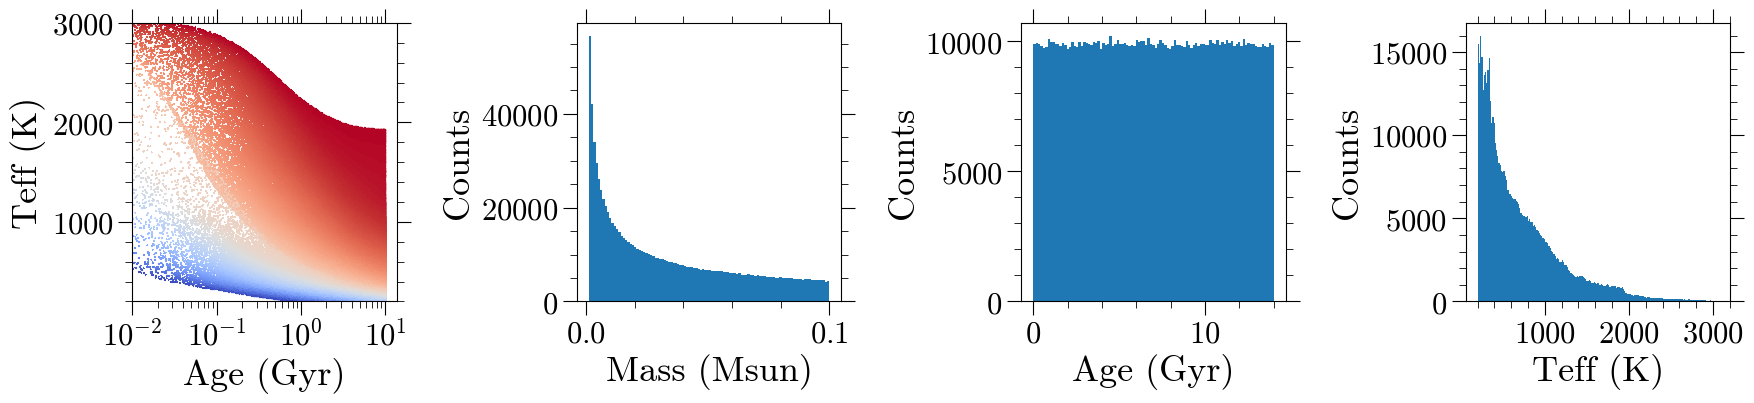

In [9]:
fig, axs=plt.subplots(ncols=4, figsize=(18, 4.5))
ax=axs[0]
ax.scatter(test['age'].values, test['temperature'].values, c=np.log10(test['mass'].values), marker='+', s=1, cmap=cmap)
plt.colorbar(c, label='log Mass (Msun)')
ax.set(ylabel='Teff (K)', xlabel='Age (Gyr)', xlim=[1e-2, 13.7],  ylim=[200, 3000], xscale='log')

ax=axs[1]
_= ax.hist(test['mass'])
ax.set(xlabel='Mass (Msun)',  ylabel='Counts')
plt.tight_layout()

ax=axs[2]
_= ax.hist(test['age'])
ax.set(xlabel='Age (Gyr)',  ylabel='Counts')

ax=axs[-1]
_= ax.hist(test['temperature'])
ax.set(xlabel='Teff (K)',  ylabel='Counts')

plt.tight_layout()

In [10]:
#normalized luminosity function



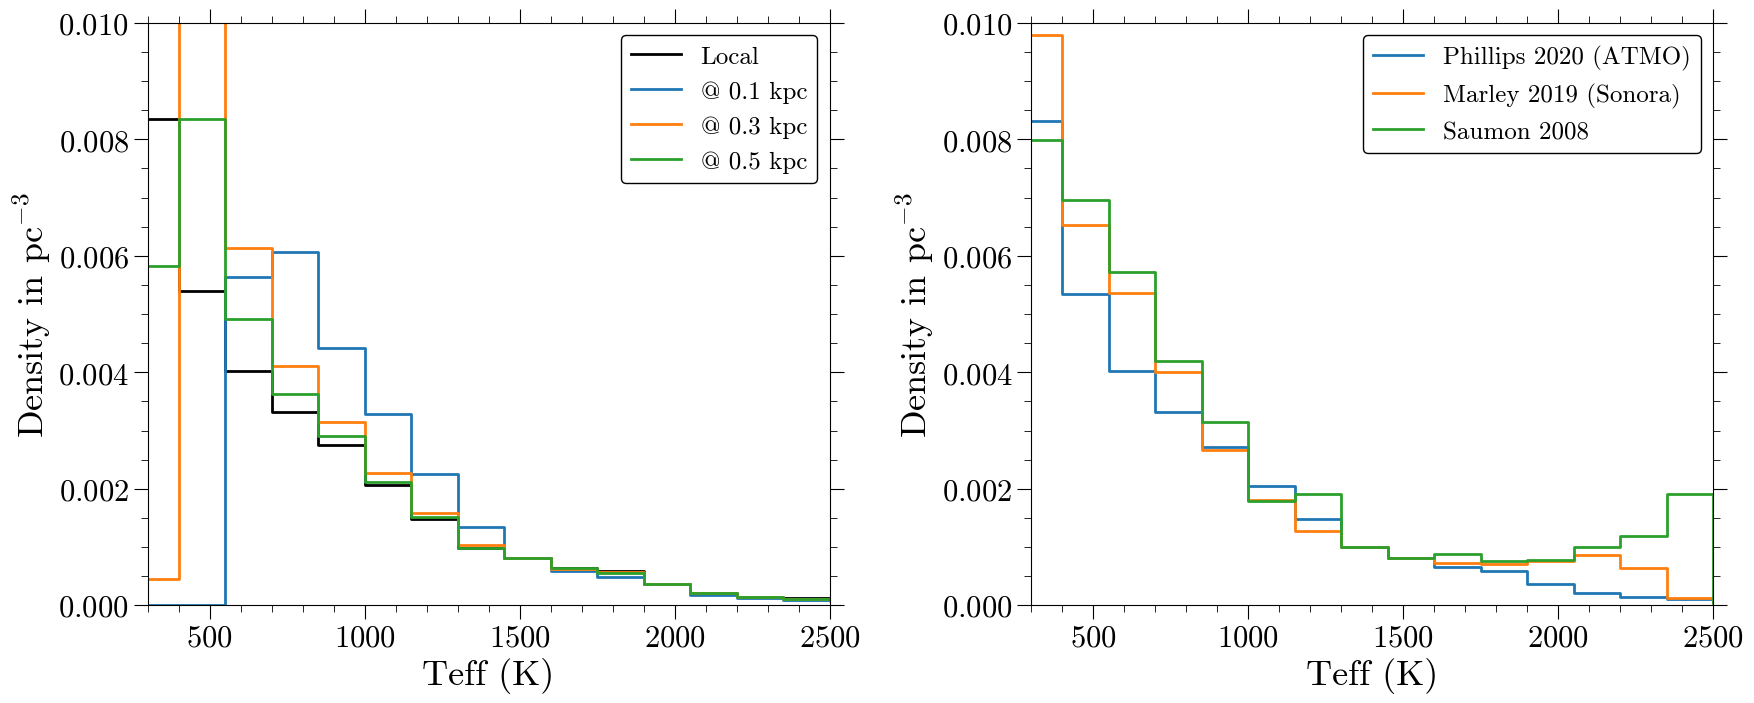

In [11]:
#compare historgram of teffs (luminosity function)
fig, axs=plt.subplots(ncols=2, figsize=(12*1.5, 5*1.5))

#difference between dark matter
ax=axs[0]
res=get_luminosity_function(atmo,interp_col='temperature')
norm_lf, bins0= normalized_lf(res['temperature'].values)
ax.step(bins0[:-1], norm_lf, where='post', linewidth=2, color='black', label='Local')


dm_data=add_dm_heat(data, 636e9*u.eV/u.cm**3)
lf=get_luminosity_function(data,interp_col='dm_teff')
norm_lf_dm, bins1= normalized_lf(lf['dm_teff'].values)
ax.step(bins1[:-1], norm_lf_dm, where='post', linewidth=2,  label='@ 0.1 kpc')

#dark matter at 0.3
dm_data=add_dm_heat(data, 116e9*u.eV/u.cm**3)
lf=get_luminosity_function(data,interp_col='dm_teff')
norm_lf_dm, bins1= normalized_lf(lf['dm_teff'].values)
ax.step(bins1[:-1], norm_lf_dm, where='post', linewidth=2,  label='@ 0.3 kpc')

dm_data=add_dm_heat(data, 54e9*u.eV/u.cm**3)
lf=get_luminosity_function(data,interp_col='dm_teff')
norm_lf_dm, bins1= normalized_lf(lf['dm_teff'].values)
ax.step(bins1[:-1], norm_lf_dm, where='post', linewidth=2,  label='@ 0.5 kpc')

ax.legend()


ax=axs[1]
res=get_luminosity_function(atmo,interp_col='temperature')
norm_lf, bins0= normalized_lf(res['temperature'].values)
ax.step(bins0[:-1], norm_lf, where='post', linewidth=2, label='Phillips 2020 (ATMO)')

res=get_luminosity_function(marley,interp_col='temperature')
norm_lf, bins0= normalized_lf(res['temperature'].values)
ax.step(bins0[:-1], norm_lf, where='post', linewidth=2, label='Marley 2019 (Sonora)')

res=get_luminosity_function(saumon,interp_col='temperature')
norm_lf, bins0= normalized_lf(res['temperature'].values)
ax.step(bins0[:-1], norm_lf, where='post', linewidth=2, label='Saumon 2008')
ax.legend()

for a in axs:
    a.set(xlabel='Teff (K)', ylabel=r'Density in pc$^{-3}$', xlim=[2500, 300], ylim=[0.,0.01])
    a.invert_xaxis()

plt.tight_layout()
plt.savefig('../fig/comparison_model_dm.pdf')